In [1]:
from datetime import datetime
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from datetime import timedelta
import pm4py
from pm4py.algo.discovery.dcr_discover.extenstions.nesting import NestVariants

# Overall idea and selling point
Mine time as the minimum delay and maximum deadline.
Mine the lifecycle of activities.
Mine choices.
Create time aware subprocesses by finding patterns:
- Self exclude, condition: required to respect timed execution semantics
- Conditions and responses between steps in the transition lifecycle for activites: The activity subprocess
Abstract away based on subprocesses:
- Remove individual choices and mine the step of making a choice: downside, the individual delays/deadlines or consequences of a choice are removed. Only the effect of making a choice is kept.
- Remove the lifecycle transition that is not equal to complete: downside, the individual effects of lifecycle transitions are not visible.
Merge the abstract log and original log: best of both worlds. see the effect of the subprocess but also the effect of the individual event.

In [3]:
log_metadata = pd.read_csv('/home/vco/Datasets/Collection_Event_Logs/Metadata.csv')
log_metadata.columns = log_metadata.columns.str.replace(r"[\s\t\n]+", "", regex=True)

In [4]:
log_metadata

,EventLogID,EventLogName,EventLogDatasetFileName,EventLogYear,DatasetSize,DatasetFormat,NumberofCases,NumberofVariants,NumberofEvents,NumberofActivities,...,%CaseCoverage(Top5Variants),MeanDuration(Top5Variants),PotentialPerformanceIssues,PerformanceIssuesNotes,ProminentExhibitedBehavior,PrimaryDependency,%PrimaryDependencyCaseCoverage,NumberofResources,ResourceType,TypeIndication
0,1,AmazonSalesReport,NaN,2024,3.2 MB,.csv,120229.0,100,128976.0,21,...,0.911070,NaN,NaN,NaN,Small Spaghetti Clusters with Linear Dominancy,"Shipped + Shipped, Shipped + Shipped",3.33,0,NaN,NaN
1,2,Artificial Digital Photo Copier Event Log,NaN,2012,285 KB,.xes,100.0,99,37873.0,68,...,0.060000,132 days 1 hour,Job,It takes 51 weeks to be able to complete this ...,Either Sequence and Loop \r\n\r\nOR Loop and D...,"Drum Spin Stop, Drum Spin Start",51.00,1,Machine,PRN1
2,3,BPI Challenge 2012,NaN,2012,3.2 MB,.csv,13087.0,4366,262200.0,36,...,0.453962,1 hour 26 minutes,"W_Nabellen incomplete dossiers-Complete, W_Nab...",Potential improvement was chosen at hand max r...,Spaghetti Behavior,"W_Completeren aanvraag-Complete, W_Completeren...",33.70,69,Numeric,"1002, 1005"
3,4,"BPI Challenge 2013, closed problems",NaN,2013,190 KB,.xes,1487.0,327,6600.0,7,...,0.595831,185 days 1 6 hours,Queued- Awaiting Assigment,The case coverage of the max duration is 34.2 ...,Small Spaghetti Clusters with Linear Dominancy,"Accepted-In Progress, Completed-Closed",80.80,585,"Name, Organisation","Ava, Org Line C"
4,5,"BPI Challenge 2013, incidents",NaN,2013,1.299 KB,.xes,7554.0,2278,65533.0,13,...,0.378343,7 days 7 hours,"Accepted + Assigned, Accepted + In Progress",For the performance issue it can be noted that...,Spaghetti Behavior,"Queued + Awaiting Assignment, Accepted + In Pr...",59.40,1440,"Name, Organisation, Country of Organisation, C...","Siebel, G97, Sweden, se"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,94,Data-driven Process Discovery - Artificial Eve...,log-20-percent-noise.xes,2016,5.624 KB,.xes,100000.0,2562,914556.0,8,...,0.205770,1 hour 25 minutes,"Check, Visit",It should be noted that the potential performa...,Small Spaghetti Clusters with Linear Dominancy,"Xray, Check",70.40,5,Nurse Name,"Joe, John, Sue, Alice"
94,95,Data-driven Process Discovery - Artificial Eve...,log-25-percent-noise.xes,2016,5.681 KB,.xes,100000.0,2793,920071.0,8,...,0.190220,1 hour 25 minutes,"Register,Check","The activity ""Check"" has the most process dura...",Small Spaghetti Clusters with Linear Dominancy,"Xray, Check",70.40,5,Nurse Name,"Joe, John, Sue, Alice"
95,96,Data-driven Process Discovery - Artificial Eve...,log-30-percent-noise.xes,2016,5.693 KB,.xes,100000.0,2946,924239.0,8,...,0.179090,1 hour 25 minutes,"Check,Visit","Even though Check,Visit only has a duration of...",Small Spaghetti Clusters with Linear Dominancy,"Xray, Check",70.30,5,Nurse Name,"Joe, John, Sue, Alice"
96,97,Data-driven Process Discovery - Artificial Eve...,log-35-percent-noise.xes,2016,6.162 KB,.xes,100000.0,3116,929432.0,8,...,0.168500,1 hour 25 minutes,"Check,Visit","Even though Check,Visit only has a duration of...",Small Spaghetti Clusters with Linear Dominancy,"Xray, Check",70.30,5,Nurse Name,"Joe, John, Sue, Alice"


In [5]:
suitable_logs = log_metadata[log_metadata['AdditionalAttributes'].str.contains('Lifecycle Transition', na=False)]

In [6]:
import numpy as np

# Clean base name
base_name = (
    suitable_logs['EventLogName']
    .str.replace(' ', '_', regex=False)
    .str.replace(',', '', regex=False)
)

# Append dataset name only if not NaN
dataset_part = suitable_logs['EventLogDatasetFileName'].fillna('')
dataset_part = np.where(dataset_part != '', '_' + dataset_part, '')

# Conditionally add DatasetFormat only if not already in EventLogDatasetFileName
add_format = ~suitable_logs.apply(
    lambda row: str(row['DatasetFormat']) in str(row['EventLogDatasetFileName']),
    axis=1
)
format_part = np.where(add_format, suitable_logs['DatasetFormat'], '')

# Final column assignment
suitable_logs['EventLogFileName'] = base_name + dataset_part + format_part

suitable_logs_list = suitable_logs['EventLogFileName'].tolist()

/tmp/ipykernel_8962/3334948440.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suitable_logs['EventLogFileName'] = base_name + dataset_part + format_part


In [7]:
import glob
import os

# Load list of suitable filenames
valid_filenames = set(sorted(suitable_logs_list))

# List and filter .xes files
xes_file_paths = glob.glob('/home/vco/Datasets/Collection_Event_Logs/*.xes')
xes_file_paths = [os.path.abspath(p) for p in xes_file_paths]
print(sorted(xes_file_paths))
xes_file_paths = [p for p in xes_file_paths if os.path.basename(p) in valid_filenames]

# List and filter .csv files, excluding Metadata.csv
csv_file_paths = glob.glob('/home/vco/Datasets/Collection_Event_Logs/*.csv')
csv_file_paths = [p for p in csv_file_paths if not p.endswith('Metadata.csv')]
csv_file_paths = [os.path.abspath(p) for p in csv_file_paths]
csv_file_paths = [p for p in csv_file_paths if os.path.basename(p) in valid_filenames]

# Print results
print("Filtered .xes files:")
print(xes_file_paths)

print("Filtered .csv files:")
print(csv_file_paths)


['/home/vco/Datasets/Collection_Event_Logs/Artificial_Digital_Photo_Copier_Event_Log.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2012.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2013_closed_problems.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2013_incidents.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_1.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_2.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_3.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_4.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_5.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2017.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2017_-_Offer_log.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2019.xes', '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_202

In [8]:
suitable_logs_list.remove('BPI_Challenge_2012.csv')
suitable_logs_list.append('BPI_Challenge_2012.xes')

In [9]:
sorted(suitable_logs_list)

['Artificial_Digital_Photo_Copier_Event_Log.xes',
 'BPI_Challenge_2012.xes',
 'BPI_Challenge_2013_closed_problems.xes',
 'BPI_Challenge_2013_incidents.xes',
 'BPI_Challenge_2015_Municipality_1.xes',
 'BPI_Challenge_2015_Municipality_2.xes',
 'BPI_Challenge_2015_Municipality_3.xes',
 'BPI_Challenge_2015_Municipality_4.xes',
 'BPI_Challenge_2015_Municipality_5.xes',
 'BPI_Challenge_2017.xes',
 'BPI_Challenge_2017_-_Offer_log.xes',
 'Data-driven_Process_Discovery_-_Artificial_Event_Log_log-0-percent-noise.xes',
 'Data-driven_Process_Discovery_-_Artificial_Event_Log_log-15-percent-noise.xes',
 'Data-driven_Process_Discovery_-_Artificial_Event_Log_log-20-percent-noise.xes',
 'Data-driven_Process_Discovery_-_Artificial_Event_Log_log-25-percent-noise.xes',
 'Data-driven_Process_Discovery_-_Artificial_Event_Log_log-30-percent-noise.xes',
 'Data-driven_Process_Discovery_-_Artificial_Event_Log_log-35-percent-noise.xes',
 'Data-driven_Process_Discovery_-_Artificial_Event_Log_log-40-percent-noise.

In [10]:
xes_file_paths

['/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2013_incidents.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_4.xes',
 '/home/vco/Datasets/Collection_Event_Logs/Sepsis_Treatment_Careflow.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2017_-_Offer_log.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_2.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_5.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_3.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2015_Municipality_1.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2017.xes',
 '/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2013_closed_problems.xes',
 '/home/vco/Datasets/Collection_Event_Logs/Artificial_Digital_Photo_Copier_Event_Log.xes']

In [10]:
# log = pm4py.read_xes('/home/vco/Projects/pm4py-dcr4py/tests/input_data/roadtraffic50traces.xes')
log = pm4py.read_xes('/home/vco/Datasets/Road_Traffic_Fine_Management_Process.xes.gz')

parsing log, completed traces :: 100%|██████████| 150370/150370 [00:15<00:00, 9957.49it/s] 


In [5]:
sepsis = "Sepsis_Cases_Event_Log.xes"
log = pm4py.read_xes(f'/home/vco/Datasets/{sepsis}')

/home/vco/.pyenv/versions/pm4py-dcr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2876.64it/s]


In [11]:
log = pm4py.read_xes('/home/vco/Datasets/Collection_Event_Logs/BPI_Challenge_2012.xes')

/home/vco/.pyenv/versions/pm4py-dcr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 13087/13087 [00:05<00:00, 2468.19it/s]


In [15]:
all_events = set(log['concept:name'].unique())

In [17]:
events_with_detailed_lifecycles = set()
subset_logs_for_event = {}
for event in all_events:
    subset_log = log[log['concept:name']==event][['case:concept:name','lifecycle:transition','time:timestamp']]
    lifecycle_transitions = subset_log['lifecycle:transition'].unique()
    if len(lifecycle_transitions) > 1:
        print(event, lifecycle_transitions)
        events_with_detailed_lifecycles.add(event)
        subset_log.rename({'lifecycle:transition':'concept:name'},axis=1,inplace=True)
        subset_logs_for_event[event] = subset_log

W_Nabellen offertes ['SCHEDULE' 'START' 'COMPLETE']
W_Completeren aanvraag ['SCHEDULE' 'START' 'COMPLETE']
W_Nabellen incomplete dossiers ['SCHEDULE' 'START' 'COMPLETE']
W_Valideren aanvraag ['SCHEDULE' 'START' 'COMPLETE']
W_Afhandelen leads ['SCHEDULE' 'START' 'COMPLETE']
W_Beoordelen fraude ['SCHEDULE' 'START' 'COMPLETE']


In [30]:
only_complete_lifecycle_log = log[log['lifecycle:transition']=='COMPLETE']

In [31]:
only_complete_lifecycle_log

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
5,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
6,10862,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
...,...,...,...,...,...,...,...
262193,11119,COMPLETE,W_Nabellen offertes,2012-03-10 12:50:54.881000+00:00,2012-02-29 23:43:09.766000+00:00,214373,8500
262194,112,COMPLETE,A_SUBMITTED,2012-02-29 23:51:16.799000+00:00,2012-02-29 23:51:16.799000+00:00,214376,15000
262195,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+00:00,2012-02-29 23:51:16.799000+00:00,214376,15000
262198,11169,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+00:00,2012-02-29 23:51:16.799000+00:00,214376,15000


In [18]:
lifecycle_graphs_for_event = {}
for event, subset_log in subset_logs_for_event.items():
    graph, timings = pm4py.discover_dcr(subset_log, post_process={'timed'})
    lifecycle_graphs_for_event[event] = graph

W_Nabellen offertes


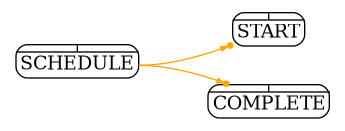

W_Completeren aanvraag


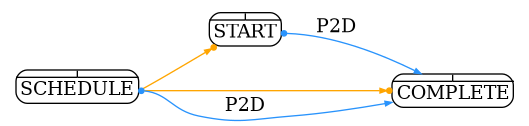

W_Nabellen incomplete dossiers


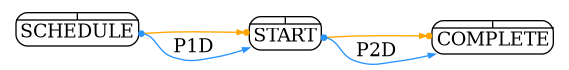

W_Valideren aanvraag


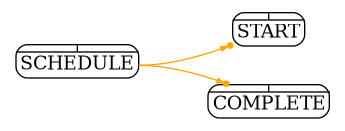

W_Afhandelen leads


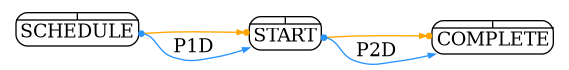

W_Beoordelen fraude


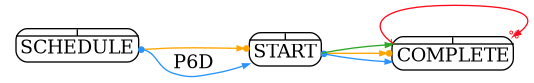

In [27]:
for event, graph in lifecycle_graphs_for_event.items():
    print(event)
    pm4py.view_dcr(graph)

In [20]:
from copy import deepcopy

In [25]:
domain_knowledge_abstraction_log = deepcopy(log)
domain_knowledge_abstraction_log['concept:name'] = domain_knowledge_abstraction_log['concept:name'].apply(
    lambda x: x.split('_')[0])
subprocess_graph, subprocess_timings = pm4py.discover_dcr(domain_knowledge_abstraction_log, post_process={'timed'})

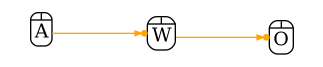

In [26]:
pm4py.view_dcr(subprocess_graph)

In [32]:
lifecycle_in_event_log = deepcopy(log)
lifecycle_in_event_log['concept:name'] = lifecycle_in_event_log['concept:name'] + '+' + lifecycle_in_event_log['lifecycle:transition']

In [34]:
lifecycle_in_event_graph, _ = pm4py.discover_dcr(lifecycle_in_event_log, post_process={'nesting','timed'},nest_variant=NestVariants.CHOICE)

In [35]:
graph, timings = pm4py.discover_dcr(log,post_process={'nesting','timed'},nest_variant=NestVariants.CHOICE)

In [49]:
def handle_timed_condition_subprocess(graph, delay_cutoff: timedelta = timedelta(hours=1)):
    self_excludes = set()
    for source,targets in graph.excludes.items():
        if source in targets:
            self_excludes.add(source)

    for group, events in graph.nestedgroups.items():
        if group in self_excludes:
            self_excludes.remove(group)
            self_excludes = self_excludes.union(events)

    source_condition_remapping = {}
    for target, sources_dict in graph.timedconditions.items():
        for source, timing in list(sources_dict.items()):
            if timing < delay_cutoff:
                del graph.timedconditions[target][source]
            elif source in self_excludes:
                if source not in graph.subprocesses:
                    condition_subprocess = f'{source}_ne'
                    graph.subprocesses[condition_subprocess] = {source}
                    source_condition_remapping[source] = condition_subprocess
                    graph.events.add(condition_subprocess)
                    graph.labels.add(condition_subprocess)
                    graph.label_map[condition_subprocess] = condition_subprocess
                    graph.marking.included.add(condition_subprocess)

                    for group, events in graph.nestedgroups.items():
                        if source in events:
                            graph.nestedgroups[group].remove(source)
                            graph.nestedgroups[group].add(condition_subprocess)

    for k,v in list(graph.timedconditions.items()):
        if len(v)==0:
            del graph.timedconditions[k]

    for target, sources in graph.conditions.items():
        for source in sources:
            if source in source_condition_remapping:
                graph.conditions[target].remove(source)
                graph.conditions[target].add(source_condition_remapping[source])
                the_delay = graph.timedconditions[target][source]
                del graph.timedconditions[target][source]
                graph.timedconditions[target][source_condition_remapping[source]] = the_delay
    return graph

In [52]:
lifecycle_in_event_graph = handle_timed_condition_subprocess(lifecycle_in_event_graph)

In [50]:
graph = handle_timed_condition_subprocess(graph)

In [74]:
def lifecycle_graph_update(graph,lifecycle_graphs_for_event,subprocess_graph):
    events_by_prefix = {
        sp_prefix: set([e for e in graph.events if e.startswith(sp_prefix)])
        for sp_prefix in ['A', 'W', 'O']
    }
    # events_by_prefix['O'].remove('O_SENT')
    graph.events = graph.events.union(set(['A', 'W', 'O']))
    graph.labels = graph.labels.union(set(['A', 'W', 'O']))
    graph.label_map['A'] = 'A'
    graph.label_map['W'] = 'W'
    graph.label_map['O'] = 'O'
    graph.conditions = {**graph.conditions, **subprocess_graph.conditions}
    graph.timedconditions = {**graph.timedconditions, **subprocess_graph.timedconditions}
    graph.marking.included = graph.marking.included.union(set(['A', 'W', 'O']))
    graph.subprocesses = {**graph.subprocesses, **events_by_prefix}
    for lf_subprocess, lf_graph in lifecycle_graphs_for_event.items():
        graph.events.add(lf_subprocess)
        graph.labels.add(lf_subprocess)
        graph.label_map[lf_subprocess] = lf_subprocess
        graph.marking.included.add(lf_subprocess)
        graph.subprocesses[lf_subprocess] = set([f"{lf_subprocess}+{e}" for e in lf_graph.events])
        graph.timedconditions = {**graph.timedconditions, **lf_graph.timedconditions}
        graph.conditions = {**graph.conditions, **lf_graph.conditions}
        graph.responses = {**graph.responses, **lf_graph.responses}
        graph.includes = {**graph.includes, **lf_graph.includes}
        graph.excludes = {**graph.excludes, **lf_graph.excludes}
    return graph

In [68]:
graph

<super: <class 'DistributedDcrGraph'>, <TimedDcrGraph object>>events: {'W_Nabellen incomplete dossiers', 'W_Nabellen offertes', 'A_ACTIVATED', 'O', 'O_CANCELLED', 'A_FINALIZED', 'O_DECLINED', 'O_SENT', 'O_SENT_BACK', 'Choice2', 'W_Valideren aanvraag', 'W', 'O_CREATED', 'W_Afhandelen leads', 'A_APPROVED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_ACCEPTED', 'A_REGISTERED', 'W_Beoordelen fraude', 'O_SENT_ne', 'W_Completeren aanvraag', 'A_SUBMITTED', 'O_ACCEPTED', 'O_SELECTED', 'W_Wijzigen contractgegevens', 'A_DECLINED', 'A', 'A_CANCELLED', 'Choice1'}
marking: {executed: set(), included: {'W_Nabellen incomplete dossiers', 'W_Nabellen offertes', 'A_ACTIVATED', 'O', 'O_CANCELLED', 'A_FINALIZED', 'O_DECLINED', 'O_SENT', 'O_SENT_BACK', 'Choice2', 'W_Valideren aanvraag', 'W', 'O_CREATED', 'W_Afhandelen leads', 'A_APPROVED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_ACCEPTED', 'A_REGISTERED', 'W_Beoordelen fraude', 'O_SENT_ne', 'W_Completeren aanvraag', 'A_SUBMITTED', 'O_ACCEPTED', 'O_SELECTED',

In [75]:
lifecycle_in_event_graph = lifecycle_graph_update(lifecycle_in_event_graph,lifecycle_graphs_for_event,subprocess_graph)

In [76]:
from pm4py.objects.dcr.exporter import exporter as dcr_exporter
dcr_exporter.apply(lifecycle_in_event_graph, '/home/vco/Projects/delay-deadline-miner/models/lifecycle_in_event_graph2.xml')

# LLM labels my subprocesses

In [8]:
preceded_list = []
succeeded_list = []
subprocess_activities_list = []
no_of_activities = len(subprocess_activities_list)
preceded = f""" They are preceded by {preceded_list}.""" if len(preceded_list) > 0 else ""
succeeded = f""" They are succeeded by {succeeded_list}.""" if len(succeeded_list) > 0 else ""
json_answer = {
  "label": ""
}
prompt = f"""
In a process model I have {no_of_activities} activities labeled: {subprocess_activities_list}.{preceded}{succeeded} As much as possible try to provide a single word label.
Create a label for the subprocess which contains the {no_of_activities} activities. ONLY WRITE THE ANSWER!!! ALWAYS RETURN THE ANSWER IN THIS JSON OBJECT:
{json_answer}
"""

# Old Code

In [3]:
# from copy import deepcopy
#
# import pandas as pd
# from typing import Optional, Any, Union, Dict
# import pm4py
# from pm4py.objects.dcr.obj import DcrGraph
# from pm4py.util import exec_utils, constants, xes_constants
# from pm4py.objects.dcr.timed.obj import TimedDcrGraph
# from pm4py.objects.log.obj import EventLog
#
# class TimeMining:
#     """
#     The TimeMining provides a simple algorithm to mine timing data of an event log for DCR graphs
#
#     After initialization, user can call mine(log, G, parameters), which will return a DCR Graph with time.
#
#     Attributes
#     ----------
#     graph: Dict[str,Any]
#
#     Methods
#     -------
#     mine(log, G, parameters)
#
#     Notes
#     ------
#     *
#     """
#     def __init__(self):
#         self.idx_list = []
#         self.timing_dict = {"conditionsForDelays": {}, "responseToDeadlines": {}}
#
#
#     def get_log_with_pair(self, event_log, e1, e2):
#         '''
#         when selecting the case ids (cids) here there is a difference when taking
#         strictly less than < and strictly less than or equal <=
#         Less than or equal <= allows for instant executions (so a time of 0 between events e1 and e2)
#         '''
#         first_e1 = event_log[event_log['concept:name'] == e1].groupby('case:concept:name')[
#             ['case:concept:name', 'time:timestamp']].first().reset_index(drop=True)
#         subset_is_in = first_e1.merge(event_log, on='case:concept:name', how='inner', suffixes=('_e1', ''))
#         cids = subset_is_in[
#             ((subset_is_in['time:timestamp_e1'] <= subset_is_in['time:timestamp']) & (subset_is_in['concept:name'] == e2))][
#             'case:concept:name'].unique()
#         return event_log[event_log['case:concept:name'].isin(cids)].copy(deep=True)
#
#
#     def get_delta_between_events(self, filtered_df, event_pair, rule=None):
#         e1 = event_pair[0]
#         e2 = event_pair[1]
#         filtered_df = filtered_df[['case:concept:name', 'concept:name', 'time:timestamp']]
#         filtered_df = filtered_df[filtered_df['concept:name'].isin(event_pair)]
#         filtered_df['time:timestamp'] = pd.to_datetime(filtered_df['time:timestamp'], utc=True)
#         deltas = []
#         deltas_map = {}
#         # for idx, g in filtered_df[filtered_df['concept:name'].isin([e1, e2])].groupby('case:concept:name'):
#         for idx, g in filtered_df.groupby('case:concept:name'):
#             g = g.sort_values(by='time:timestamp').reset_index(drop=True)
#             g['time:timestamp:to'] = g['time:timestamp'].shift(-1)
#             g['concept:name:to'] = g['concept:name'].shift(-1)
#             temp_df = deepcopy(g)
#             res = []
#             if rule == 'RESPONSE':
#                 g_e1 = deepcopy(g[g['concept:name'] == e1])
#                 if len(g_e1) >= 1:
#                     g_e1 = g_e1.reset_index(drop=False)
#                     g_e1['index_below'] = g_e1['index'].shift(-1)
#                     g_e1 = g_e1[((g_e1['index_below'] - g_e1['index']) == 1)]
#                     g_e1['delta'] = g_e1['time:timestamp:to'] - g_e1['time:timestamp']
#                     res.extend(g_e1['delta'])
#                 temp_df = temp_df[
#                     (temp_df['concept:name'] == e1) & (temp_df['concept:name:to'] == e2)]
#                 temp_df['delta'] = temp_df['time:timestamp:to'] - temp_df['time:timestamp']
#                 res.extend(temp_df['delta'])
#             elif rule == 'CONDITION':
#                 temp_df = temp_df[
#                     (temp_df['concept:name'] == e1) & (temp_df['concept:name:to'] == e2)]
#                 temp_df['delta'] = temp_df['time:timestamp:to'] - temp_df['time:timestamp']
#                 res.extend(temp_df['delta'])
#             else:
#                 temp_df = temp_df[
#                     (temp_df['concept:name'] == e1) & (temp_df['concept:name:to'] == e2)]
#                 temp_df['delta'] = temp_df['time:timestamp:to'] - temp_df['time:timestamp']
#                 res.extend(temp_df['delta'])
#             deltas.extend(res)
#             for i in set(res):
#                 if i not in deltas_map:
#                     deltas_map[i] = set()
#                 deltas_map[i].add(idx)
#         return deltas, deltas_map
#
#
#     def get_filter_map(self, log: Union[pd.DataFrame, EventLog], graph):
#         # perform mining on event logs
#         if not isinstance(log, pd.DataFrame):
#             log = pm4py.convert_to_dataframe(log)
#         activities = log['case:concept:name'].unique()
#         print(log.index)
#
#         timing_input_dict = {'CONDITION': set(), 'RESPONSE': set()}
#         for e1 in graph.conditions.keys():
#             for e2 in graph.conditions[e1]:
#                 timing_input_dict['CONDITION'].add((e2, e1))
#
#         for e1 in graph.responses.keys():
#             for e2 in graph.responses[e1]:
#                 timing_input_dict['RESPONSE'].add((e1, e2))
#
#         res_filter_map = {}
#         timings = {}
#         for rule, event_pairs in timing_input_dict.items():
#             for event_pair in event_pairs:
#                 if event_pair[0] in activities and event_pair[1] in activities:
#                     data, filter_map = self.get_timings_one_relation(log,event_pair[0], event_pair[1], rule)
#                     timings[(rule, event_pair[0], event_pair[1])] = data
#                     res_filter_map[(rule, event_pair[0], event_pair[1])] = filter_map
#
#         return timings, res_filter_map
#
#     def get_timings_one_relation(self,log, e1, e2, rule):
#         filtered_df = self.get_log_with_pair(log, e1, e2)
#         data, filter_map = self.get_delta_between_events(filtered_df, (e1,e2), rule)
#         return data, filter_map

In [7]:
# tm = TimeMining()
# tm.get_filter_map(log,graph)

RangeIndex(start=0, stop=201, step=1)


({}, {})